In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Rutas base
BASE_DIR = Path("..")
PROCESSED_DIR = BASE_DIR / "processed"

# Cargar dataset con anomalías (salida del libro 03)
data_path = PROCESSED_DIR / "suelos_anomalias.csv"
print("Cargando datos desde:", data_path.resolve())

df = pd.read_csv(data_path)
print("Dimensiones del dataset:", df.shape)
df.head()


Cargando datos desde: D:\ICD-SOIL\processed\suelos_anomalias.csv
Dimensiones del dataset: (35111, 44)


C:\Users\diego\AppData\Local\Temp\ipykernel_12648\101720625.py:25: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


,secuencial,fecha_de_an_lisis,departamento,municipio,cultivo,estado,tiempo_de_establecimiento,topografia,drenaje,riego,...,hierro_olsen,manganeso_olsen,zinc_olsen,hierro_doble_acido,manganeso_doble_acido,zinc_doble_acido,iso_score,lof_score,anom_score_global,is_outlier
0,1,2014-07-01,NARIÑO,SAN ANDRÉS DE TUMACO,No Indica,No indica,No indica,No indica,No indica,No indica,...,66.39,1.700,1.500,NaN,NaN,NaN,0.040404,0.0,0.020202,0
1,164,2014-05-09,CUNDINAMARCA,UNE,Lulo,Establecido,De 0 a 1 año,Plano,Buen drenaje,Aspersión,...,222.00,3.599,2.500,NaN,NaN,NaN,0.040200,0.0,0.020100,0
2,165,2014-05-09,CUNDINAMARCA,UNE,Lulo,Establecido,De 0 a 1 año,Ondulado,Buen drenaje,Aspersión,...,345.00,3.900,7.000,NaN,NaN,NaN,0.182721,0.0,0.091361,1
3,166,2014-05-09,CUNDINAMARCA,FUNZA,Guisantes,Por establecer,No indica,Plano,Buen drenaje,Goteo,...,102.00,3.599,7.500,NaN,NaN,NaN,0.096554,0.0,0.048277,0
4,167,2014-05-09,VALLE DEL CAUCA,LA UNIÓN,Guanábana,Establecido,Mas de 10 años,Plano,Buen drenaje,Manguera,...,8.10,0.800,1.799,NaN,NaN,NaN,0.331227,0.0,0.165614,1


In [3]:
# Lista de variables de suelo generales
VARIABLES_SUELO = [
    "ph_agua_suelo", "materia_organica", "fosforo_bray_ii", "azufre_fosfato_monocalcico",
    "acidez_intercambiable", "aluminio_intercambiable", "calcio_intercambiable",
    "magnesio_intercambiable", "potasio_intercambiable", "sodio_intercambiable",
    "cic", "conductividad_electrica", "hierro_olsen", "cobre_disponible",
    "manganeso_olsen", "zinc_olsen", "boro_disponible",
    "hierro_doble_acido", "cobre_doble_acido", "manganeso_doble_acido", "zinc_doble_acido"
]

# Nos quedamos solo con las que realmente están en el dataframe
vars_present = [v for v in VARIABLES_SUELO if v in df.columns]
print("Variables de suelo disponibles en el dataset:")
print(vars_present)

# Definimos variables objetivo (targets) para modelado detallado:
# → por defecto: todas las que tengan un mínimo de datos no nulos.
MIN_DATOS = 200

TARGET_VARS = [
    v for v in vars_present
    if df[v].notna().sum() >= MIN_DATOS
]

print(f"\nVariables objetivo seleccionadas (al menos {MIN_DATOS} datos no nulos):")
print(TARGET_VARS)


Variables de suelo disponibles en el dataset:
['ph_agua_suelo', 'materia_organica', 'fosforo_bray_ii', 'azufre_fosfato_monocalcico', 'acidez_intercambiable', 'aluminio_intercambiable', 'calcio_intercambiable', 'magnesio_intercambiable', 'potasio_intercambiable', 'sodio_intercambiable', 'cic', 'conductividad_electrica', 'hierro_olsen', 'cobre_disponible', 'manganeso_olsen', 'zinc_olsen', 'boro_disponible', 'hierro_doble_acido', 'manganeso_doble_acido', 'zinc_doble_acido']

Variables objetivo seleccionadas (al menos 200 datos no nulos):
['ph_agua_suelo', 'materia_organica', 'fosforo_bray_ii', 'azufre_fosfato_monocalcico', 'acidez_intercambiable', 'aluminio_intercambiable', 'calcio_intercambiable', 'magnesio_intercambiable', 'potasio_intercambiable', 'sodio_intercambiable', 'cic', 'conductividad_electrica', 'hierro_olsen', 'cobre_disponible', 'manganeso_olsen', 'zinc_olsen', 'boro_disponible', 'hierro_doble_acido', 'manganeso_doble_acido']


In [4]:
def entrenar_modelo_y_icd(df, target_var, feature_vars, test_size=0.2, random_state=42):
    """
    Entrena un modelo RandomForestRegressor para una variable objetivo (target_var)
    usando feature_vars como predictores.

    Devuelve:
    - pipeline entrenado (imputación + escalado + RF)
    - métricas (MAE, RMSE, R2) sobre conjunto de test
    - Serie con icd_predictivo_<target_var> por registro (0–1, donde 1 = muy coherente)
    """

    # y (target) y X (features) a partir del dataframe completo
    y_full = df[target_var]
    X_full = df[feature_vars]

    # Filtrar filas con target no nulo para entrenamiento/evaluación
    mask_train = y_full.notna()
    y = y_full[mask_train]
    X = X_full[mask_train]

    if len(y) < 100:
        print(f"⚠ Muy pocos datos no nulos para {target_var} ({len(y)} filas). Se omite.")
        return None, None, None

    # Train/test split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Pipeline: imputación + escalado + modelo
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            random_state=random_state,
            n_jobs=-1
        ))
    ])

    # Entrenar
    pipe.fit(X_tr, y_tr)

    # Evaluación en test
    y_pred_test = pipe.predict(X_te)
    mae = mean_absolute_error(y_te, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred_test))
    r2 = r2_score(y_te, y_pred_test)

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "n_train": len(y_tr),
        "n_test": len(y_te)
    }

    # ===== ICD PREDICTIVO POR REGISTRO =====
    # Queremos medir qué tan coherente es el valor medido con lo que "espera" el modelo.
    # 1) Predecimos para todas las filas donde y_full no es NaN
    y_pred_all = pipe.predict(X)

    # 2) Calculamos error absoluto
    abs_error = np.abs(y_pred_all - y)

    # 3) Escalamos el error a un score 0–1:
    #    - errores pequeños → score cercano a 1 (muy coherente)
    #    - errores grandes → score cercano a 0
    #    Usamos el percentil 95 del error como umbral "máx razonable".
    q95 = np.quantile(abs_error, 0.95)
    if q95 == 0:
        q95 = abs_error.max() if abs_error.max() > 0 else 1.0

    icd_vals = 1 - np.clip(abs_error / (q95 + 1e-6), 0, 1)

    icd_series = pd.Series(index=df.index, dtype=float, name=f"icd_predictivo_{target_var}")
    icd_series.loc[mask_train] = icd_vals

    return pipe, metrics, icd_series


In [5]:
modelos = {}
metricas = []
icd_columns = []

for target in TARGET_VARS:
    print(f"\n🔍 Entrenando modelo para variable objetivo: {target}")

    feature_vars = [v for v in vars_present if v != target]

    if len(feature_vars) == 0:
        print(f"⚠ No hay variables predictoras para {target}. Se omite.")
        continue

    pipe, metrics, icd_series = entrenar_modelo_y_icd(df, target, feature_vars)

    if pipe is None:
        continue

    modelos[target] = pipe
    metricas.append({
        "variable": target,
        **metrics
    })

    # Añadir columna ICD predictivo al dataframe
    col_name = icd_series.name
    df[col_name] = icd_series
    icd_columns.append(col_name)

    print(f"  → MAE  = {metrics['MAE']:.4f}")
    print(f"  → RMSE = {metrics['RMSE']:.4f}")
    print(f"  → R2   = {metrics['R2']:.4f}")



🔍 Entrenando modelo para variable objetivo: ph_agua_suelo
  → MAE  = 0.2062
  → RMSE = 0.2993
  → R2   = 0.9140

🔍 Entrenando modelo para variable objetivo: materia_organica
  → MAE  = 1.7445
  → RMSE = 2.9184
  → R2   = 0.5293

🔍 Entrenando modelo para variable objetivo: fosforo_bray_ii
  → MAE  = 22.9534
  → RMSE = 56.3522
  → R2   = 0.4373

🔍 Entrenando modelo para variable objetivo: azufre_fosfato_monocalcico
  → MAE  = 7.7000
  → RMSE = 41.9106
  → R2   = 0.5343

🔍 Entrenando modelo para variable objetivo: acidez_intercambiable
  → MAE  = 0.1585
  → RMSE = 0.2906
  → R2   = 0.9809

🔍 Entrenando modelo para variable objetivo: aluminio_intercambiable
  → MAE  = 0.1436
  → RMSE = 0.2687
  → R2   = 0.9780

🔍 Entrenando modelo para variable objetivo: calcio_intercambiable
  → MAE  = 0.3101
  → RMSE = 1.3342
  → R2   = 0.9782

🔍 Entrenando modelo para variable objetivo: magnesio_intercambiable
  → MAE  = 0.2694
  → RMSE = 0.6671
  → R2   = 0.9389

🔍 Entrenando modelo para variable obje

D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_doble_acido' 'manganeso_doble_acido' 'zinc_doble_acido']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_doble_acido' 'manganeso_doble_acido' 'zinc_doble_acido']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_doble_acido' 'manganeso_doble_acido' 'zinc_doble_acido']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


  → MAE  = 111.2413
  → RMSE = 216.4387
  → R2   = 0.5424

🔍 Entrenando modelo para variable objetivo: cobre_disponible


D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_doble_acido' 'manganeso_doble_acido' 'zinc_doble_acido']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_doble_acido' 'manganeso_doble_acido' 'zinc_doble_acido']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_doble_acido' 'manganeso_doble_acido' 'zinc_doble_acido']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


  → MAE  = 1.8079
  → RMSE = 3.6476
  → R2   = 0.3197

🔍 Entrenando modelo para variable objetivo: manganeso_olsen


D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_doble_acido' 'manganeso_doble_acido' 'zinc_doble_acido']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_doble_acido' 'manganeso_doble_acido' 'zinc_doble_acido']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_doble_acido' 'manganeso_doble_acido' 'zinc_doble_acido']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


  → MAE  = 4.7163
  → RMSE = 10.3913
  → R2   = 0.4160

🔍 Entrenando modelo para variable objetivo: zinc_olsen


D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_doble_acido' 'manganeso_doble_acido' 'zinc_doble_acido']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_doble_acido' 'manganeso_doble_acido' 'zinc_doble_acido']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_doble_acido' 'manganeso_doble_acido' 'zinc_doble_acido']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


  → MAE  = 3.2200
  → RMSE = 9.2681
  → R2   = 0.3658

🔍 Entrenando modelo para variable objetivo: boro_disponible
  → MAE  = 0.1145
  → RMSE = 0.2043
  → R2   = 0.6146

🔍 Entrenando modelo para variable objetivo: hierro_doble_acido


D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_olsen' 'cobre_disponible' 'manganeso_olsen' 'zinc_olsen']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_olsen' 'cobre_disponible' 'manganeso_olsen' 'zinc_olsen']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_olsen' 'cobre_disponible' 'manganeso_olsen' 'zinc_olsen']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


  → MAE  = 22.7837
  → RMSE = 35.6278
  → R2   = 0.4148

🔍 Entrenando modelo para variable objetivo: manganeso_doble_acido


D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_olsen' 'cobre_disponible' 'manganeso_olsen' 'zinc_olsen']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


  → MAE  = 4.6449
  → RMSE = 9.5611
  → R2   = 0.4365


D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_olsen' 'cobre_disponible' 'manganeso_olsen' 'zinc_olsen']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
D:\ICD-SOIL\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['hierro_olsen' 'cobre_disponible' 'manganeso_olsen' 'zinc_olsen']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [6]:
if metricas:
    metrics_df = pd.DataFrame(metricas).sort_values("R2", ascending=False)
    metrics_df
else:
    print("⚠ No se entrenó ningún modelo (revisa TARGET_VARS y datos disponibles).")


C:\Users\diego\AppData\Local\Temp\ipykernel_12648\486687639.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x="R2", y="variable", palette="viridis")


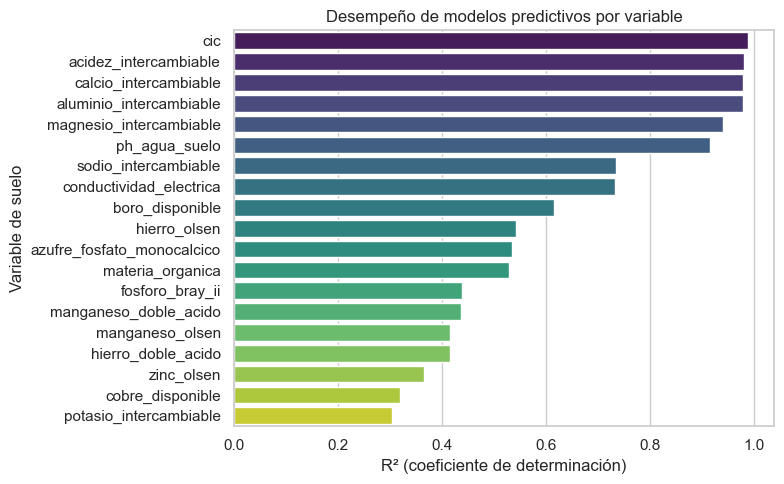

In [7]:
# Visualización rápida de R2 por variable
if metricas:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=metrics_df, x="R2", y="variable", palette="viridis")
    plt.xlabel("R² (coeficiente de determinación)")
    plt.ylabel("Variable de suelo")
    plt.title("Desempeño de modelos predictivos por variable")
    plt.tight_layout()
    plt.show()


In [8]:
print("Columnas ICD predictivo creadas:")
print(icd_columns)

# Guardamos el dataframe completo, CON:
# - datos originales
# - anom_score_global, is_outlier (del libro 03)
# - icd_predictivo_<variable> (de este libro 04)
output_path = PROCESSED_DIR / "suelos_coherencia.csv"
df.to_csv(output_path, index=False, encoding="utf-8")
print("💾 Dataset con coherencia predictiva guardado en:", output_path.resolve())

# Guardamos también las métricas de los modelos
if metricas:
    metrics_path = PROCESSED_DIR / "metrics_modelos_predictivos.csv"
    metrics_df.to_csv(metrics_path, index=False, encoding="utf-8")
    print("📊 Métricas de los modelos guardadas en:", metrics_path.resolve())


Columnas ICD predictivo creadas:
['icd_predictivo_ph_agua_suelo', 'icd_predictivo_materia_organica', 'icd_predictivo_fosforo_bray_ii', 'icd_predictivo_azufre_fosfato_monocalcico', 'icd_predictivo_acidez_intercambiable', 'icd_predictivo_aluminio_intercambiable', 'icd_predictivo_calcio_intercambiable', 'icd_predictivo_magnesio_intercambiable', 'icd_predictivo_potasio_intercambiable', 'icd_predictivo_sodio_intercambiable', 'icd_predictivo_cic', 'icd_predictivo_conductividad_electrica', 'icd_predictivo_hierro_olsen', 'icd_predictivo_cobre_disponible', 'icd_predictivo_manganeso_olsen', 'icd_predictivo_zinc_olsen', 'icd_predictivo_boro_disponible', 'icd_predictivo_hierro_doble_acido', 'icd_predictivo_manganeso_doble_acido']
💾 Dataset con coherencia predictiva guardado en: D:\ICD-SOIL\processed\suelos_coherencia.csv
📊 Métricas de los modelos guardadas en: D:\ICD-SOIL\processed\metrics_modelos_predictivos.csv


In [9]:
import joblib

MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

for var, pipe in modelos.items():
    model_path = MODELS_DIR / f"modelo_rf_{var}.joblib"
    joblib.dump(pipe, model_path)
    print(f"🤖 Modelo para {var} guardado en:", model_path.resolve())


🤖 Modelo para ph_agua_suelo guardado en: D:\ICD-SOIL\models\modelo_rf_ph_agua_suelo.joblib
🤖 Modelo para materia_organica guardado en: D:\ICD-SOIL\models\modelo_rf_materia_organica.joblib
🤖 Modelo para fosforo_bray_ii guardado en: D:\ICD-SOIL\models\modelo_rf_fosforo_bray_ii.joblib
🤖 Modelo para azufre_fosfato_monocalcico guardado en: D:\ICD-SOIL\models\modelo_rf_azufre_fosfato_monocalcico.joblib
🤖 Modelo para acidez_intercambiable guardado en: D:\ICD-SOIL\models\modelo_rf_acidez_intercambiable.joblib
🤖 Modelo para aluminio_intercambiable guardado en: D:\ICD-SOIL\models\modelo_rf_aluminio_intercambiable.joblib
🤖 Modelo para calcio_intercambiable guardado en: D:\ICD-SOIL\models\modelo_rf_calcio_intercambiable.joblib
🤖 Modelo para magnesio_intercambiable guardado en: D:\ICD-SOIL\models\modelo_rf_magnesio_intercambiable.joblib
🤖 Modelo para potasio_intercambiable guardado en: D:\ICD-SOIL\models\modelo_rf_potasio_intercambiable.joblib
🤖 Modelo para sodio_intercambiable guardado en: D:\ICD-